In [1]:
import os
import io
import time
import json
import base64
import hashlib
import numpy as np
from tqdm import tqdm
from pathlib import Path
from io import BytesIO
from dotenv import load_dotenv
from PIL import Image
import cohere
import mimetypes
from openai import OpenAI
from pdf2image import convert_from_path
import cohere  


In [2]:
# ==== CONFIG ====
PDF_FOLDER = "source_docs"
IMG_FOLDER = "images"
HASHES_FOLDER = "hashes"
PDF_HASH_FILE = "pdf_hashes.json"
IMG_EMB_FILE = "image_embeddings.json"
MODEL_NAME = "embed-v4.0"

os.makedirs(PDF_FOLDER, exist_ok=True)
os.makedirs(IMG_FOLDER, exist_ok=True)
os.makedirs(HASHES_FOLDER, exist_ok=True)

In [3]:
# Load API keys
load_dotenv()
co = cohere.ClientV2(api_key=os.getenv("COHERE_API_KEY"))
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [4]:
# ==== HELPERS ====
def hash_file(filepath: str) -> str:
    sha256 = hashlib.sha256()
    with open(filepath, "rb") as f:
        while chunk := f.read(8192):
            sha256.update(chunk)
    return sha256.hexdigest()


def base64_from_image(img_path: str) -> str:
    with open(img_path, "rb") as f:
        b64_data = base64.b64encode(f.read()).decode("utf-8")
    mime_type, _ = mimetypes.guess_type(img_path)
    if not mime_type:
        mime_type = "image/png"  # fallback
    return f"data:{mime_type};base64,{b64_data}"


def embed_image(co, img_path: str):
    api_input_document = {
        "content": [{"type": "image", "image": base64_from_image(img_path)}]
    }
    api_response = co.embed(
        model=MODEL_NAME,
        input_type="search_document",
        embedding_types=["float"],
        inputs=[api_input_document],
    )
    return np.asarray(api_response.embeddings.float[0])


def convert_pdf_to_images(pdf_path: str, output_dir: str) -> list:
    pdf_name = Path(pdf_path).stem
    images = convert_from_path(pdf_path, dpi=200)
    image_paths = []

    for i, img in enumerate(images):
        img_filename = f"{pdf_name}_page{i + 1}.png"
        img_path = os.path.join(output_dir, img_filename)
        img.save(img_path, "PNG")
        image_paths.append(img_path)

    return image_paths


def load_json(path: str) -> dict:
    return json.load(open(path)) if os.path.exists(path) else {}


def save_json(path: str, data: dict):
    with open(path, "w") as f:
        json.dump(data, f, indent=2)

In [5]:
# ==== MAIN PIPELINE ====
def process_pdfs_and_embed_pages(co):
    pdf_hash_path = os.path.join(HASHES_FOLDER, PDF_HASH_FILE)
    img_emb_path = os.path.join(HASHES_FOLDER, IMG_EMB_FILE)

    pdf_hashes = load_json(pdf_hash_path)
    image_embeddings = load_json(img_emb_path)

    new_embeddings = 0

    for pdf_file in tqdm(os.listdir(PDF_FOLDER)):
        if not pdf_file.lower().endswith(".pdf"):
            continue

        pdf_path = os.path.join(PDF_FOLDER, pdf_file)
        pdf_name = Path(pdf_file).stem
        current_hash = hash_file(pdf_path)

        if pdf_name in pdf_hashes and pdf_hashes[pdf_name] == current_hash:
            print(f"✅ Skipping (unchanged): {pdf_file}")
            continue

        # New or changed PDF
        print(f"🔄 Processing: {pdf_file}")
        image_paths = convert_pdf_to_images(pdf_path, IMG_FOLDER)

        for img_path in image_paths:
            img_name = os.path.basename(img_path)

            if img_name in image_embeddings:
                continue  # image already embedded (unlikely for new PDF)

            emb = embed_image(co, img_path)
            image_embeddings[img_name] = emb.tolist()
            new_embeddings += 1

        # Save new hash
        pdf_hashes[pdf_name] = current_hash

    # Save updated JSONs
    save_json(pdf_hash_path, pdf_hashes)
    save_json(img_emb_path, image_embeddings)

    print(f"\n✅ Total embeddings stored: {len(image_embeddings)}")
    print(f"🆕 New embeddings added: {new_embeddings}")

In [16]:
process_pdfs_and_embed_pages(co)

 20%|██        | 1/5 [00:00<00:01,  3.75it/s]

✅ Skipping (unchanged): 2020TrustFundAnnualReports.pdf


 40%|████      | 2/5 [00:00<00:01,  2.41it/s]

✅ Skipping (unchanged): 2021TrustFundAnnualReports.pdf


 60%|██████    | 3/5 [00:01<00:00,  2.47it/s]

✅ Skipping (unchanged): 2022TrustFundAnnualReports.pdf


100%|██████████| 5/5 [00:01<00:00,  2.51it/s]

✅ Skipping (unchanged): 2023TrustFundAnnualReports.pdf
✅ Skipping (unchanged): 2024TrustFundAnnualReports.pdf



✅ Total embeddings stored: 381
🆕 New embeddings added: 0


In [7]:
# Convert images to a base64 string before sending it to the API
def base64_from_image(img_path):
    pil_image = Image.open(img_path)
    img_format = pil_image.format if pil_image.format else "PNG"

    # resize_image(pil_image)

    with io.BytesIO() as img_buffer:
        pil_image.save(img_buffer, format=img_format)
        img_buffer.seek(0)
        img_data = f"data:image/{img_format.lower()};base64,"+base64.b64encode(img_buffer.read()).decode("utf-8")

    return img_data

In [8]:
def retry(retries=3, backoff=2):
    def decorator(fn):
        def wrapper(*args, **kwargs):
            delay = backoff
            for attempt in range(retries):
                try:
                    return fn(*args, **kwargs)
                except Exception as e:
                    print(f"Attempt {attempt + 1} failed — retrying in {delay}s: {e}")
                    time.sleep(delay)
                    delay *= 2
            raise RuntimeError("All retries failed")
        return wrapper
    return decorator


In [9]:
@retry(retries=4, backoff=3)
def get_query_embedding(question: str, co) -> np.ndarray:
    """Generates an embedding for a given query string."""
    resp = co.embed(
        model=MODEL_NAME,
        input_type="search_query",
        embedding_types=["float"],
        texts=[question],
    )
    return np.asarray(resp.embeddings.float[0])

In [10]:
def load_image_embeddings(embeddings_path: str):
    """Load image embeddings and corresponding filenames."""
    with open(embeddings_path, "r") as f:
        image_embeddings = json.load(f)

    filenames = list(image_embeddings.keys())
    embeddings = np.vstack(list(image_embeddings.values()))
    
    return embeddings, filenames


In [11]:
def search_image_by_question(question: str, co, max_size=800,
                             embeddings_path="hashes/image_embeddings.json",
                             image_folder="images",
                             n_results=3) -> list:
    """
    Embeds the query, searches for the top-N most similar image pages,
    and returns the matched image paths.
    """
    # Step 1: Get query embedding
    query_emb = get_query_embedding(question, co)

    # Step 2: Load embeddings and filenames
    embeddings, filenames = load_image_embeddings(embeddings_path)

    # Step 3: Compute cosine similarity (dot product for normalized vectors)
    scores = np.dot(query_emb, embeddings.T)
    top_indices = np.argsort(scores)[::-1][:n_results]

    matched_paths = []
    for idx in top_indices:
        img_path = os.path.join(image_folder, filenames[idx])

        # Display image (optional)
        img = Image.open(img_path)
        img.thumbnail((max_size, max_size))
        img.show()

        matched_paths.append(img_path)

    return matched_paths


In [12]:
def encode_image_to_base64(img_path: str) -> str:
    """Encodes an image to base64 for embedding in a prompt."""
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image not found: {img_path}")
    with open(img_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode("utf-8")


def answer_question_about_images(question: str, matched_paths: list, client: OpenAI,
                                 model="gpt-4.1-mini", verbose=True) -> str:
    """
    Sends a multimodal prompt (text + multiple images) to the LLM and returns the answer.

    Parameters:
    - question (str): User query
    - matched_paths (list): List of local image paths
    - client: OpenAI or AzureOpenAI client
    - model (str): Model to use (e.g., gpt-4.1-mini, gpt-4o)
    - verbose (bool): Whether to print the response

    Returns:
    - response text
    """
    try:
        # Encode each image to base64 and build image_url blocks
        image_contents = []
        for img_path in matched_paths:
            b64 = encode_image_to_base64(img_path)
            image_contents.append({"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}})

        # Combine the text question and the images
        message_content = [{"type": "text", "text": f"Answer clearly: {question}"}] + image_contents

        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": message_content},
            ],
            max_tokens=1000,
        )

        answer_text = response.choices[0].message.content.strip()
        if verbose:
            print("🧠 LLM Response:", answer_text)

        return answer_text

    except Exception as e:
        print(f"❌ Error processing images or getting response: {e}")
        return "Error occurred during processing."


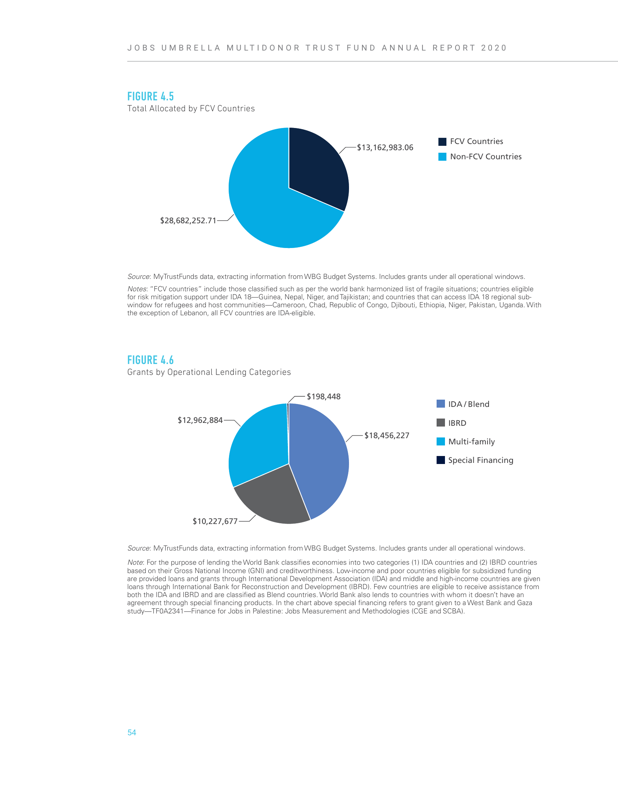

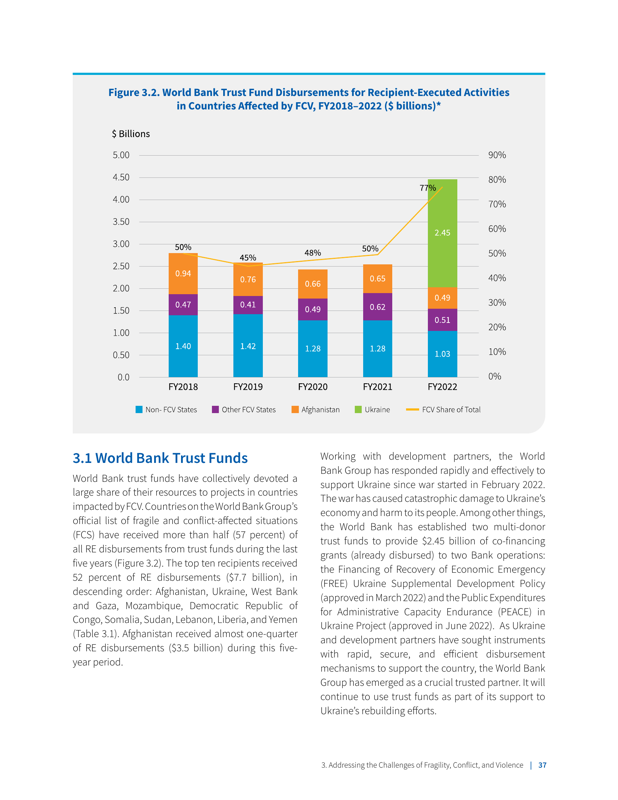

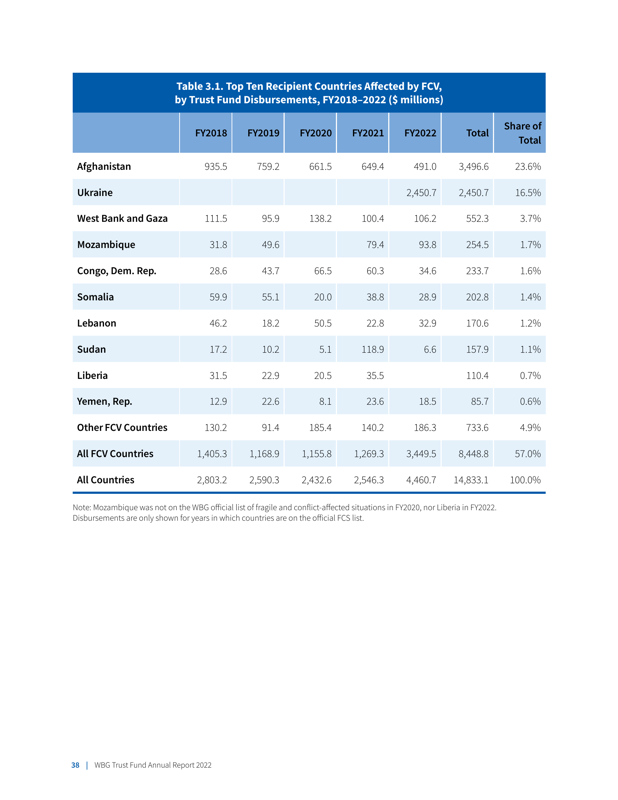

In [14]:
img_paths = search_image_by_question("What was the total money/donation allocated by fcv countries ?", co)

In [17]:
img_paths

['images/2020TrustFundAnnualReports_page62.png',
 'images/2022TrustFundAnnualReports_page36.png',
 'images/2022TrustFundAnnualReports_page37.png']

In [ ]:
answer = answer_question_about_images("What was the total money/donation allocated by fcv countries ?", img_paths, client)

🧠 LLM Response: The total money/donation allocated by FCV countries is $13,162,983.06 according to Figure 4.5. 

Additionally, from Table 3.1, the total trust fund disbursements for all FCV countries during FY2018–2022 amount to $8,448.8 million (or $8.4488 billion).
